In [5]:
import sagemaker
import boto3
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np

In [13]:
!mkdir -p code

In [283]:
%%writefile code/inference.py

import torch
from diffusers import StableDiffusionImg2ImgPipeline
import json
from PIL import Image
import numpy as np

device="cuda"
# model_name = "nitrosocke/Ghibli-Diffusion"
# model_name = "stabilityai/stable-diffusion-2-1-base"
model_name = "hakurei/waifu-diffusion"

def model_fn(model_dir):
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_name, 
        torch_dtype=torch.float32).to(
            device
    )
    return pipe

# def input_fn(data, content_type):
#     return "data"

def predict_fn(data, model):
    if type(data) == str:
        data = json.loads(data)

    prompt = data["prompt"]
    neg_prompt = data["negative_prompt"]
    image = data["image"]
    strength = data["strength"]
    guidance_scale = data["guidance_scale"]
    num_inference_steps = data["num_inference_steps"]
    seed = data["seed"]
    
    image = Image.fromarray(np.array(image).astype('uint8'), 'RGB') # converts list to np array and then to PIL image
    
    generator = torch.Generator(device=device).manual_seed(seed)
    output_image = model(prompt=prompt, 
                         negative_prompt=neg_prompt,
                         image=image, 
                         strength=strength, 
                         guidance_scale=guidance_scale, 
                         num_inference_steps=num_inference_steps, 
                         generator=generator
                        ).images[0]
    return output_image

def output_fn(prediction, accept):
    return {
        "output_image": np.array(prediction).tolist()
    }

Overwriting code/inference.py


In [284]:
%%writefile code/requirements.txt

diffusers==0.17.1
accelerate==0.20.3
Pillow==9.5.0

Overwriting code/requirements.txt


In [285]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

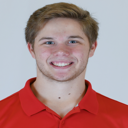

In [286]:
input_image = Image.open("ProfilePic.jpg").convert("RGB")

# input_image = input_image.resize((768, 768))
input_image = input_image.resize((128, 128))
input_image

In [287]:
s3_location = f's3://{bucket}/image-to-image/model.tar.gz'

In [288]:
!tar zcvf model.tar.gz code/

code/
code/requirements.txt
code/inference.py


In [289]:
!aws s3 cp model.tar.gz $s3_location

upload: ./model.tar.gz to s3://sagemaker-us-east-1-971684222125/image-to-image/model.tar.gz


In [290]:
from sagemaker.huggingface.model import HuggingFaceModel


# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_location,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.26",  # transformers version used
   pytorch_version="1.13",        # pytorch version used
   py_version='py39',            # python version used
)

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

--------!

In [291]:
# from sagemaker import Predictor
# model_name = "huggingface-pytorch-inference-2023-06-21-16-07-11-400"
# endpoint_name = "huggingface-pytorch-inference-2023-06-21-16-07-12-326"
# predictor = Predictor(
#     endpoint_name = endpoint_name
# )

In [292]:
def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response

In [293]:
image_name = "ProfilePic.jpg"

In [294]:
# image_array = np.array(input_image).tolist()

In [295]:
# np_array = np.array(input_image)

In [296]:
# Image.fromarray(np_array.astype('uint8'), 'RGB')

In [299]:
import base64
from PIL import Image
# from io import BytesIO


# content_type = 'application/json;jpeg', endpoint expects payload to be a json with the low resolution jpeg image as bytes encoded with base64.b64 encoding.
# To send raw image to the endpoint, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
content_type = "application/json"


image_name = "ProfilePic.jpg"
input_image = Image.open(image_name).convert("RGB").resize((256, 256))

encoded_image = np.array(input_image).tolist()

payload = {
    # "prompt": "ghibli style, portrait, headshot",
    "prompt": "anime version of headshot, highest quality",
    "negative_prompt": "creepy, background, fuzzy",
    "image": encoded_image,
    "strength": 0.75,
    "guidance_scale": 7.5,
    "num_inference_steps": 50,
    "seed": 2
}


# For accept = 'application/json;jpeg', endpoint returns the jpeg image as bytes encoded with base64.b64 encoding.
# To receive raw image with rgb value set Accept = 'application/json'
accept = "application/json"

# Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.

# query_response = query(predictor, json.dumps(payload).encode("utf-8"), content_type, accept)
query_response = query(predictor, json.dumps(payload), content_type, accept)

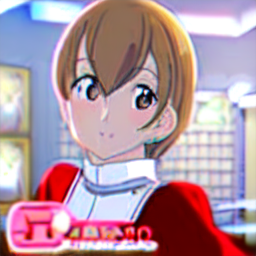

In [300]:
Image.fromarray(np.array(query_response['output_image']).astype('uint8'), 'RGB')

In [280]:
# predictor.delete_endpoint()